In [1]:
# Import pyNBS modules
from pyNBS import data_import_tools as dit
from pyNBS import network_propagation as prop
from pyNBS import pyNBS_core as core
from pyNBS import pyNBS_single
from pyNBS import consensus_clustering as cc
from pyNBS import pyNBS_plotting as plot

# Import other needed packages
import os
import time
import pandas as pd
import numpy as np
from IPython.display import Image

# Import packages needed for measuring clustering similarity
from sklearn.metrics.cluster import adjusted_mutual_info_score, adjusted_rand_score
import scipy.stats as stats

### In this notebook, we will explore how various decisions to use different underlying data or choosing not to execute certain parts of the pyNBS algorithm will affect the final clustering results of the same cohort. We will use the TCGA Bladder Cancer (BLCA) cohort as the example here.

### Loading the binary somatic mutation data

For more examples and definitions in the somatic mutation data file format, please see our Github Wiki page:  
https://github.com/huangger/pyNBS/wiki/Somatic-Mutation-Data-File-Format

In [2]:
sm_data_filepath = './Supplementary_Notebook_Data/BLCA_sm_data.txt'
sm_mat = dit.load_binary_mutation_data(sm_data_filepath, filetype='list', delimiter='\t')

Binary Mutation Matrix Loaded: ./Supplementary_Notebook_Data/BLCA_sm_data.txt


# pyNBS on BLCA with Cancer Subnetwork
In this section, we will use an abridged version of the example [CancerSubnetwork_BLCA](https://github.com/huangger/pyNBS/blob/master/Examples/CancerSubnetwork_BLCA_pyNBS_Notebook.ipynb) notebook for explinatory purposes, but for subsequent sections, the explanation is generally the same with the changes made to the base agorithm described underneath the header for each new pyNBS execution.

### Load molecular networks

For more examples and definitions in the network file format, please see our Github Wiki page:  
https://github.com/huangger/pyNBS/wiki/Molecular-Network-File-Format

We will load the Cancer Subnetwork described in the Application Note, a degree-preserved shuffle of the Cancer Subnetwork, and a HUGO Symbol version of the the top 10% of the HumanNet network (aka HM90, used originally to stratify the OV cohort in Hofree et al. 2013). 

In [3]:
# Load Cancer Specific Network
CSN = dit.load_network_file('./Supplementary_Notebook_Data/CancerSubnetwork.txt')

Network File Loaded: ./Supplementary_Notebook_Data/CancerSubnetwork.txt


In [4]:
# Optional: Setting the output directory for files to be saved in
outdir = './Supplementary_Notebook_Results/'

# Optional: Creating above output directory if it doesn't already exist
if not os.path.exists(outdir):
    os.makedirs(outdir)
    
# Optional: Setting a filename prefix for all files saved to outdir
job_name = 'BLCA_CSN_base'

# Constructs dictionary to be passed as "save_args" to functions if output to be saved
save_args = {'outdir': outdir, 'job_name': job_name}

### Construct each regularization graph for use in network-regularized NMF

For additional notes on the graph laplacian construction method, please visit our GitHub wiki for this function:
https://github.com/huangger/pyNBS/wiki/pyNBS.pyNBS_core.network_inf_KNN_glap

In [5]:
# Constructing knnGlap
CSN_knnGlap = core.network_inf_KNN_glap(CSN)

Graph influence matrix calculated: 3.27066993713 seconds
Graph laplacian of KNN network from influence matrix calculated: 9.99563598633 seconds


### Construct network propagation kernel matrix for each network

For additional notes on the propagation methods used, please visit our GitHub wiki for this function:
https://github.com/huangger/pyNBS/wiki/pyNBS.network_propagation.network_propagation

In [6]:
# We will use the default alpha value for each propagation
alpha = 0.7
# Construct network propagation kernel for CSN
# Construct identity matrix of network
CSN_network_nodes = CSN.nodes()
CSN_network_I = pd.DataFrame(np.identity(len(CSN_network_nodes)), index=CSN_network_nodes, columns=CSN_network_nodes)
CSN_kernel = prop.network_propagation(CSN, CSN_network_I, alpha=alpha, symmetric_norm=False)

Performing network propagation with alpha: 0.7
Network Propagation Complete: 7.13661289215 seconds


### Applying the pyNBS Algorithm
Here, we will apply the traditional pyNBS algorithm on the BLCA somatic mutation data on each of the networks we have loaded above and generate patient clusters from using these different underlying networks. Some of the subsequent sections may present variations on the original NBS algorithm. The default number of clusters constructed by pyNBS is k=3, but we have observed that k=4 may produce better survival separation, so we use that value for all subsequent pyNBS runs here. We will also use the default number of pyNBS iterations (100) for the subsequent consensus clustering step (if applicable).

These functions for each step here are wrapped by the [```NBS_single```](https://github.com/huangger/pyNBS/wiki/pyNBS.pyNBS_single.NBS_single) function, which calls each step above in sequence to perform a single iteration of the pyNBS algorithm.

In [7]:
clusters, niter = 4, 100

# Run pyNBS
BLCA_CSN_Hlist = []
for i in range(niter):
    # Run pyNBS core steps and save resulting H matrix to Hlist
    BLCA_CSN_Hlist.append(pyNBS_single.NBS_single(sm_mat, CSN_knnGlap, propNet=CSN, propNet_kernel=CSN_kernel, k=clusters))

### Consensus Clustering

For more information on how the consensus clustering is performed, please see our wiki page on this function:
https://github.com/huangger/pyNBS/wiki/pyNBS.consensus_clustering.consensus_hclust_hard

In [8]:
# Consensus Clustering
BLCA_CSN_NBS_cc_table, BLCA_CSN_NBS_cc_linkage, BLCA_CSN_NBS_cluster_assign = cc.consensus_hclust_hard(BLCA_CSN_Hlist, k=clusters, **save_args)

Constructing Hlist: 100 cluster matrices,  393 samples
Hlist consensus constructed and sample clusters assigned


### Survival analysis

Additional details on the survival data file format is also describe on our Github wiki at: 
https://github.com/huangger/pyNBS/wiki/Patient-Survival-Data-File-Format

In [9]:
# Load survival Data
BLCA_surv_data = './Supplementary_Notebook_Data/BLCA.clin.merged.surv.txt'

/cellar/users/jkhuang/anaconda/lib/python2.7/site-packages/numpy/core/fromnumeric.py:225: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return reshape(newshape, order=order)


Multi-Class Log-Rank P: 0.00546874306938
Kaplan Meier Plot constructed


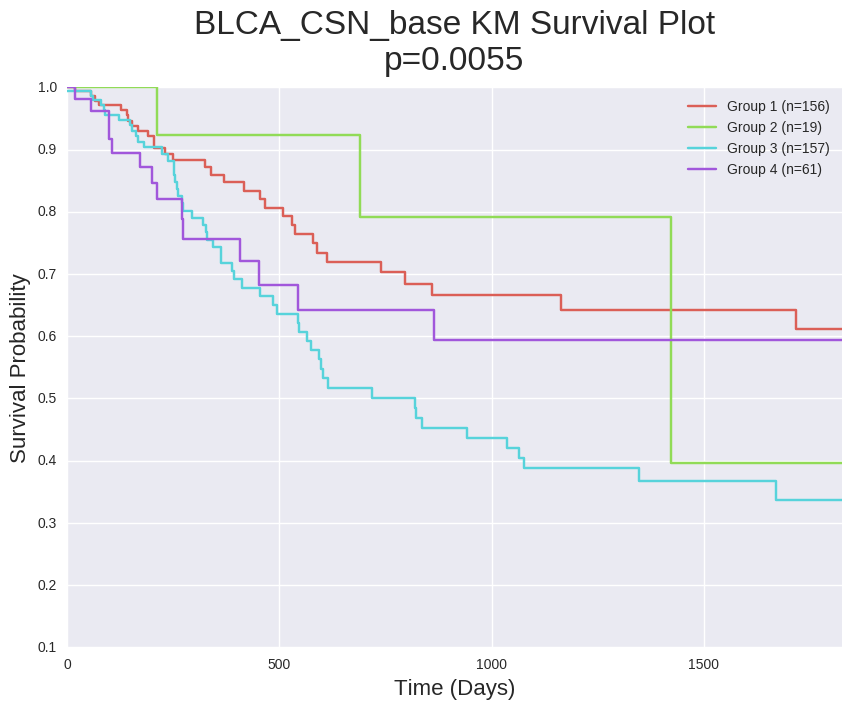

In [10]:
# Plot KM Plot for patient clusters
BLCA_CSN_p = plot.cluster_KMplot(BLCA_CSN_NBS_cluster_assign, BLCA_surv_data, delimiter=',', **save_args)
Image(filename = save_args['outdir']+save_args['job_name']+'_KM_plot.png', width=600, height=600)

# pyNBS on BLCA with shuffled Cancer Subnetwork

In [11]:
# Load Shuffled version of Cancer Specific Network
CSNshuff = dit.load_network_file('./Supplementary_Notebook_Data/CancerSubnetwork.txt', degree_shuffle=True)

Network File Loaded: ./Supplementary_Notebook_Data/CancerSubnetwork.txt
Network shuffled: 34.4114289284 seconds. Edge similarity: 0.241762165388


In [12]:
# Optional: Setting a filename prefix for all files saved to outdir
save_args['job_name'] = 'BLCA_CSNshuff'

In [13]:
# Constructing knnGlap
CSNshuff_knnGlap = core.network_inf_KNN_glap(CSNshuff)

Graph influence matrix calculated: 3.94558119774 seconds
Graph laplacian of KNN network from influence matrix calculated: 10.8507220745 seconds


In [14]:
# Construct network propagation kernel for CSNshuff
# Construct identity matrix of network
CSNshuff_network_nodes = CSNshuff.nodes()
CSNshuff_network_I = pd.DataFrame(np.identity(len(CSNshuff_network_nodes)), index=CSNshuff_network_nodes, columns=CSNshuff_network_nodes)
CSNshuff_kernel = prop.network_propagation(CSNshuff, CSNshuff_network_I, alpha=alpha, symmetric_norm=False)

Performing network propagation with alpha: 0.7
Network Propagation Complete: 8.0382771492 seconds


In [15]:
clusters, niter = 4, 100

# Run pyNBS
BLCA_CSNshuff_Hlist = []
for i in range(niter):
    # Run pyNBS core steps and save resulting H matrix to Hlist
    BLCA_CSNshuff_Hlist.append(pyNBS_single.NBS_single(sm_mat, CSNshuff_knnGlap, propNet=CSNshuff, propNet_kernel=CSNshuff_kernel, k=clusters))

In [16]:
# Consensus Clustering
BLCA_CSNshuff_NBS_cc_table, BLCA_CSNshuff_NBS_cc_linkage, BLCA_CSNshuff_NBS_cluster_assign = cc.consensus_hclust_hard(BLCA_CSNshuff_Hlist, k=clusters, **save_args)

Constructing Hlist: 100 cluster matrices,  393 samples
Hlist consensus constructed and sample clusters assigned


Multi-Class Log-Rank P: 0.00831591713097
Kaplan Meier Plot constructed


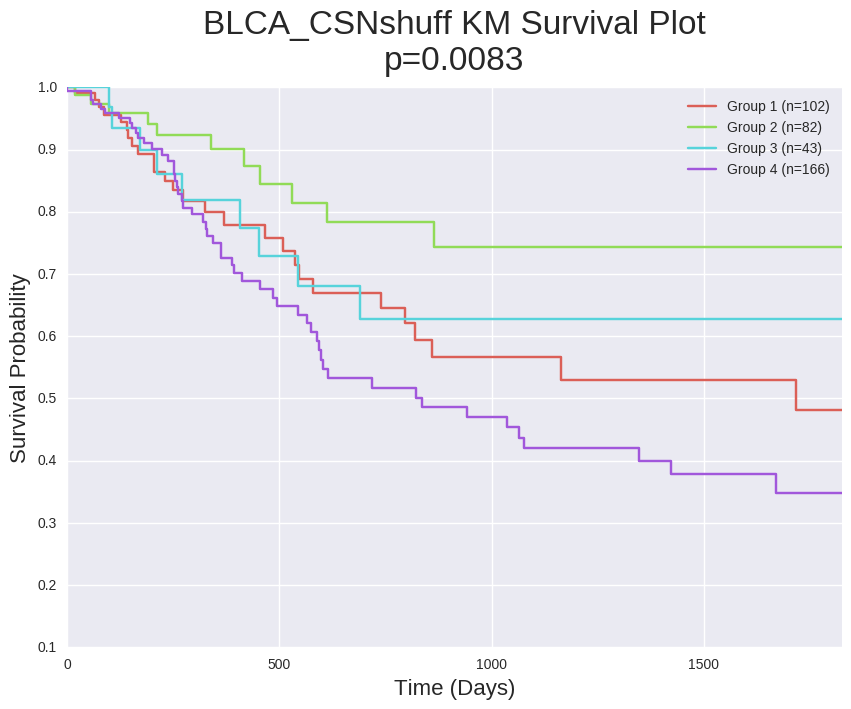

In [17]:
# Plot KM Plot for patient clusters
BLCA_CSNshuff_p = plot.cluster_KMplot(BLCA_CSNshuff_NBS_cluster_assign, BLCA_surv_data, delimiter=',', **save_args)
Image(filename = save_args['outdir']+save_args['job_name']+'_KM_plot.png', width=600, height=600)

### Agreement with BLCA pyNBS results under normal algorithm deployment
We now use the similarity techniques when comparing pyNBS results to the original Hofree et al results (see the [```OV```]() or [```UCEC```]() Hofree examples for more details) to compare the results of this pyNBS run to the base BLCA pyNBS results with default values on the cancer subnetwork with k=4.

In [18]:
cc_align = pd.concat([BLCA_CSN_NBS_cluster_assign, BLCA_CSNshuff_NBS_cluster_assign], axis=1).dropna()
cc_align.columns = ['Base', 'New']
base_clust_assign, new_clust_assign = cc_align['Base'], cc_align['New']
adj_rand_index = adjusted_rand_score(base_clust_assign, new_clust_assign)
adj_mutual_info_score = adjusted_mutual_info_score(base_clust_assign, new_clust_assign)
print 'Adjusted Rand Index is: ' + str(adj_rand_index)
print 'Adjusted Mutual Info Score is: ' + str(adj_mutual_info_score)

Adjusted Rand Index is: 0.554846013602
Adjusted Mutual Info Score is: 0.490671103422


In [19]:
# Construct contingency table for cluster assignments
intersect_pats = list(cc_align.index)
NBS_cont_table_array = []
for i in range(1,clusters+1):    
    base_cluster = set(base_clust_assign.ix[intersect_pats][base_clust_assign.ix[intersect_pats]==i].index)
    base_pyNBS_cluster_intersect = []
    for j in range(1,clusters+1):
        new_cluster = set(new_clust_assign.ix[intersect_pats][new_clust_assign.ix[intersect_pats]==j].index)
        base_pyNBS_cluster_intersect.append(len(base_cluster.intersection(new_cluster)))
    NBS_cont_table_array.append(base_pyNBS_cluster_intersect)
    
# Display contingency table
pd.DataFrame(NBS_cont_table_array, 
             index=['Original pyNBS Cluster '+repr(i) for i in range(1, clusters+1)],
             columns=['New pyNBS Cluster '+repr(i) for i in range(1, clusters+1)])

,New pyNBS Cluster 1,New pyNBS Cluster 2,New pyNBS Cluster 3,New pyNBS Cluster 4
Original pyNBS Cluster 1,88,63,0,5
Original pyNBS Cluster 2,4,8,1,6
Original pyNBS Cluster 3,9,2,1,145
Original pyNBS Cluster 4,1,9,41,10


In [20]:
# Calculate p-value and chi-squared statistic:
chi_sq_test = stats.chi2_contingency(NBS_cont_table_array, correction=False)
print 'Chi-Squared Statistic:', chi_sq_test[0]
print 'Chi-Squared P-Value:', chi_sq_test[1]

Chi-Squared Statistic: 526.318383321
Chi-Squared P-Value: 1.32534310419e-107


# pyNBS on BLCA with HM90

In [21]:
# Load top 10% of edges from HumanNet and convert those edges to HUGO Symbol
HM90 = dit.load_network_file('./Supplementary_Notebook_Data/HumanNet90_Symbol.txt')

Network File Loaded: ./Supplementary_Notebook_Data/HumanNet90_Symbol.txt


To perform the gene name conversions described for HM90, we used our [```gene_conversion_tools```](https://github.com/huangger/pyNBS/wiki/pyNBS.gene_conversion_tools) module in pyNBS.

In [22]:
# Optional: Setting a filename prefix for all files saved to outdir
save_args['job_name'] = 'BLCA_HM90'

In [23]:
# Constructing knnGlap
HM90_knnGlap = core.network_inf_KNN_glap(HM90)

Graph influence matrix calculated: 23.710201025 seconds
Graph laplacian of KNN network from influence matrix calculated: 46.9573550224 seconds


In [24]:
# Construct network propagation kernel for HM90
# Construct identity matrix of network
HM90_network_nodes = HM90.nodes()
HM90_network_I = pd.DataFrame(np.identity(len(HM90_network_nodes)), index=HM90_network_nodes, columns=HM90_network_nodes)
HM90_kernel = prop.network_propagation(HM90, HM90_network_I, alpha=alpha, symmetric_norm=False)

Performing network propagation with alpha: 0.7
Network Propagation Complete: 113.823643923 seconds


In [25]:
clusters, niter = 4, 100

# Run pyNBS
BLCA_HM90_Hlist = []
for i in range(niter):
    # Run pyNBS core steps and save resulting H matrix to Hlist
    BLCA_HM90_Hlist.append(pyNBS_single.NBS_single(sm_mat, HM90_knnGlap, propNet=HM90, propNet_kernel=HM90_kernel, k=clusters))

In [26]:
# Consensus Clustering
BLCA_HM90_NBS_cc_table, BLCA_HM90_NBS_cc_linkage, BLCA_HM90_NBS_cluster_assign = cc.consensus_hclust_hard(BLCA_HM90_Hlist, k=clusters, **save_args)

Constructing Hlist: 100 cluster matrices,  393 samples
Hlist consensus constructed and sample clusters assigned


Multi-Class Log-Rank P: 0.371743203315
Kaplan Meier Plot constructed


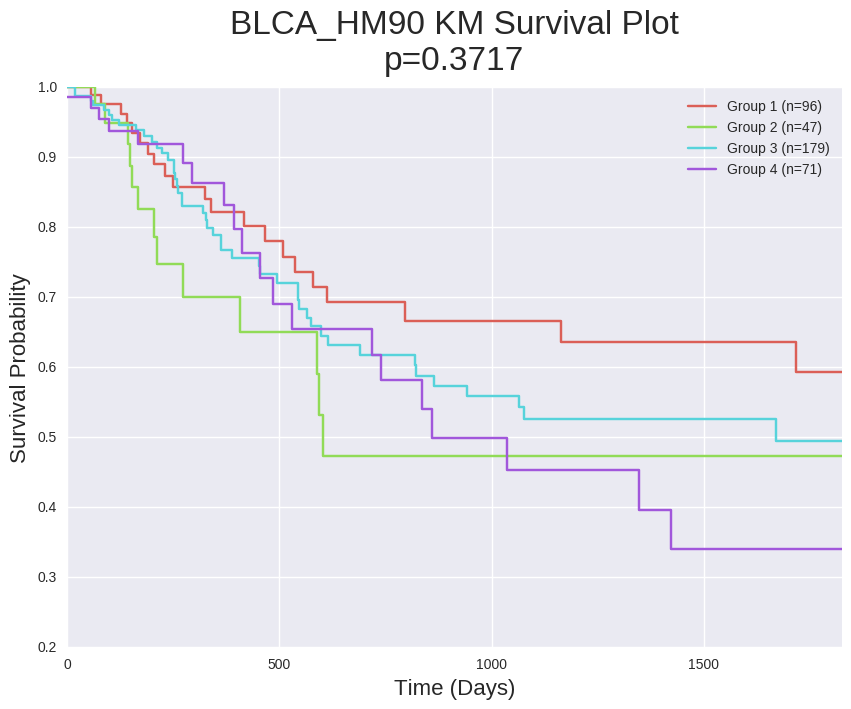

In [27]:
# Plot KM Plot for patient clusters
BLCA_HM90_p = plot.cluster_KMplot(BLCA_HM90_NBS_cluster_assign, BLCA_surv_data, delimiter=',', **save_args)
Image(filename = save_args['outdir']+save_args['job_name']+'_KM_plot.png', width=600, height=600)

### Agreement with BLCA pyNBS results under normal algorithm deployment
We now use the similarity techniques when comparing pyNBS results to the original Hofree et al results (see the [```OV```]() or [```UCEC```]() Hofree examples for more details) to compare the results of this pyNBS run to the base BLCA pyNBS results with default values on the cancer subnetwork with k=4.

In [28]:
cc_align = pd.concat([BLCA_CSN_NBS_cluster_assign, BLCA_HM90_NBS_cluster_assign], axis=1).dropna()
cc_align.columns = ['Base', 'New']
base_clust_assign, new_clust_assign = cc_align['Base'], cc_align['New']
adj_rand_index = adjusted_rand_score(base_clust_assign, new_clust_assign)
adj_mutual_info_score = adjusted_mutual_info_score(base_clust_assign, new_clust_assign)
print 'Adjusted Rand Index is: ' + str(adj_rand_index)
print 'Adjusted Mutual Info Score is: ' + str(adj_mutual_info_score)

Adjusted Rand Index is: 0.174265643299
Adjusted Mutual Info Score is: 0.170391172124


In [29]:
# Construct contingency table for cluster assignments
intersect_pats = list(cc_align.index)
NBS_cont_table_array = []
for i in range(1,clusters+1):    
    base_cluster = set(base_clust_assign.ix[intersect_pats][base_clust_assign.ix[intersect_pats]==i].index)
    base_pyNBS_cluster_intersect = []
    for j in range(1,clusters+1):
        new_cluster = set(new_clust_assign.ix[intersect_pats][new_clust_assign.ix[intersect_pats]==j].index)
        base_pyNBS_cluster_intersect.append(len(base_cluster.intersection(new_cluster)))
    NBS_cont_table_array.append(base_pyNBS_cluster_intersect)
    
# Display contingency table
pd.DataFrame(NBS_cont_table_array, 
             index=['Original pyNBS Cluster '+repr(i) for i in range(1, clusters+1)],
             columns=['New pyNBS Cluster '+repr(i) for i in range(1, clusters+1)])

,New pyNBS Cluster 1,New pyNBS Cluster 2,New pyNBS Cluster 3,New pyNBS Cluster 4
Original pyNBS Cluster 1,88,23,29,16
Original pyNBS Cluster 2,1,1,12,5
Original pyNBS Cluster 3,4,15,98,40
Original pyNBS Cluster 4,3,8,40,10


In [30]:
# Calculate p-value and chi-squared statistic:
chi_sq_test = stats.chi2_contingency(NBS_cont_table_array, correction=False)
print 'Chi-Squared Statistic:', chi_sq_test[0]
print 'Chi-Squared P-Value:', chi_sq_test[1]

Chi-Squared Statistic: 163.224827576
Chi-Squared P-Value: 1.58662786825e-30


# pyNBS on BLCA with no network propagation
Here, we perform the pyNBS algorithm using the BLCA data and default settings with k=4, but without performing any network propagation. The only place the network will be used is in constructing the regularization network for the network-regularized NMF step. The quantile normalization will be performed on the binary sub-sampled data.

In [31]:
# Optional: Setting a filename prefix for all files saved to outdir
save_args['job_name'] = 'BLCA_CSN_noprop'

Constructing Hlist: 100 cluster matrices,  393 samples
Hlist consensus constructed and sample clusters assigned
Multi-Class Log-Rank P: 0.0077766885269
Kaplan Meier Plot constructed


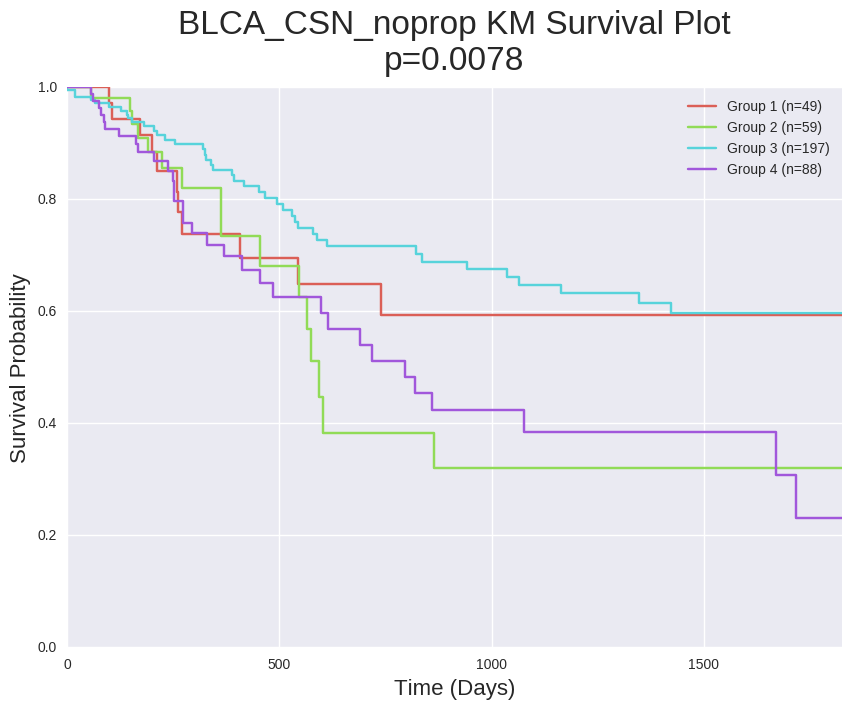

In [32]:
clusters, niters= 4, 100

# Run pyNBS
BLCA_CSN_noprop_Hlist = []
for i in range(niter):
    # Run pyNBS core steps and save resulting H matrix to Hlist
    BLCA_CSN_noprop_Hlist.append(pyNBS_single.NBS_single(sm_mat, CSN_knnGlap, k=clusters))

# Consensus Clustering
BLCA_CSN_noprop_NBS_cc_table, BLCA_CSN_noprop_NBS_cc_linkage, BLCA_CSN_noprop_NBS_cluster_assign = cc.consensus_hclust_hard(BLCA_CSN_noprop_Hlist, k=clusters, **save_args)

# Plot KM Plot for patient clusters
BLCA_CSN_noprop_p = plot.cluster_KMplot(BLCA_CSN_noprop_NBS_cluster_assign, BLCA_surv_data, delimiter=',', **save_args)
Image(filename = save_args['outdir']+save_args['job_name']+'_KM_plot.png', width=600, height=600)

### Agreement with BLCA pyNBS results under normal algorithm deployment
We now use the similarity techniques when comparing pyNBS results to the original Hofree et al results (see the [```OV```]() or [```UCEC```]() Hofree examples for more details) to compare the results of this pyNBS run to the base BLCA pyNBS results with default values on the cancer subnetwork with k=4.

In [33]:
cc_align = pd.concat([BLCA_CSN_NBS_cluster_assign, BLCA_CSN_noprop_NBS_cluster_assign], axis=1).dropna()
cc_align.columns = ['Base', 'New']
base_clust_assign, new_clust_assign = cc_align['Base'], cc_align['New']
adj_rand_index = adjusted_rand_score(base_clust_assign, new_clust_assign)
adj_mutual_info_score = adjusted_mutual_info_score(base_clust_assign, new_clust_assign)
print 'Adjusted Rand Index is: ' + str(adj_rand_index)
print 'Adjusted Mutual Info Score is: ' + str(adj_mutual_info_score)

Adjusted Rand Index is: 0.120126994202
Adjusted Mutual Info Score is: 0.127767131714


In [34]:
# Construct contingency table for cluster assignments
intersect_pats = list(cc_align.index)
NBS_cont_table_array = []
for i in range(1,clusters+1):    
    base_cluster = set(base_clust_assign.ix[intersect_pats][base_clust_assign.ix[intersect_pats]==i].index)
    base_pyNBS_cluster_intersect = []
    for j in range(1,clusters+1):
        new_cluster = set(new_clust_assign.ix[intersect_pats][new_clust_assign.ix[intersect_pats]==j].index)
        base_pyNBS_cluster_intersect.append(len(base_cluster.intersection(new_cluster)))
    NBS_cont_table_array.append(base_pyNBS_cluster_intersect)
    
# Display contingency table
pd.DataFrame(NBS_cont_table_array, 
             index=['Original pyNBS Cluster '+repr(i) for i in range(1, clusters+1)],
             columns=['New pyNBS Cluster '+repr(i) for i in range(1, clusters+1)])

,New pyNBS Cluster 1,New pyNBS Cluster 2,New pyNBS Cluster 3,New pyNBS Cluster 4
Original pyNBS Cluster 1,3,17,109,27
Original pyNBS Cluster 2,2,4,9,4
Original pyNBS Cluster 3,9,35,61,52
Original pyNBS Cluster 4,35,3,18,5


In [35]:
# Calculate p-value and chi-squared statistic:
chi_sq_test = stats.chi2_contingency(NBS_cont_table_array, correction=False)
print 'Chi-Squared Statistic:', chi_sq_test[0]
print 'Chi-Squared P-Value:', chi_sq_test[1]

Chi-Squared Statistic: 166.951803729
Chi-Squared P-Value: 2.66113231387e-31


# pyNBS on BLCA with no network regularization
Here, we perform the pyNBS algorithm using the BLCA data and default settings with k=4, but without constructing the regularization for the network-regularized NMF. The somatic mutation data will still be propgated over the Cancer Subnetwork, but the regularization term in the [```mixed_netNMF```](https://github.com/huangger/pyNBS/wiki/pyNBS.pyNBS_core.mixed_netNMF) step will be set to 0.

In [36]:
# Optional: Setting a filename prefix for all files saved to outdir
save_args['job_name'] = 'BLCA_CSN_noreg'
# Setting lambda value (regularization constant) to 0
NBS_single_params = {'netNMF_lambda':'0'}

Constructing Hlist: 100 cluster matrices,  393 samples
Hlist consensus constructed and sample clusters assigned
Multi-Class Log-Rank P: 0.0132966217938
Kaplan Meier Plot constructed


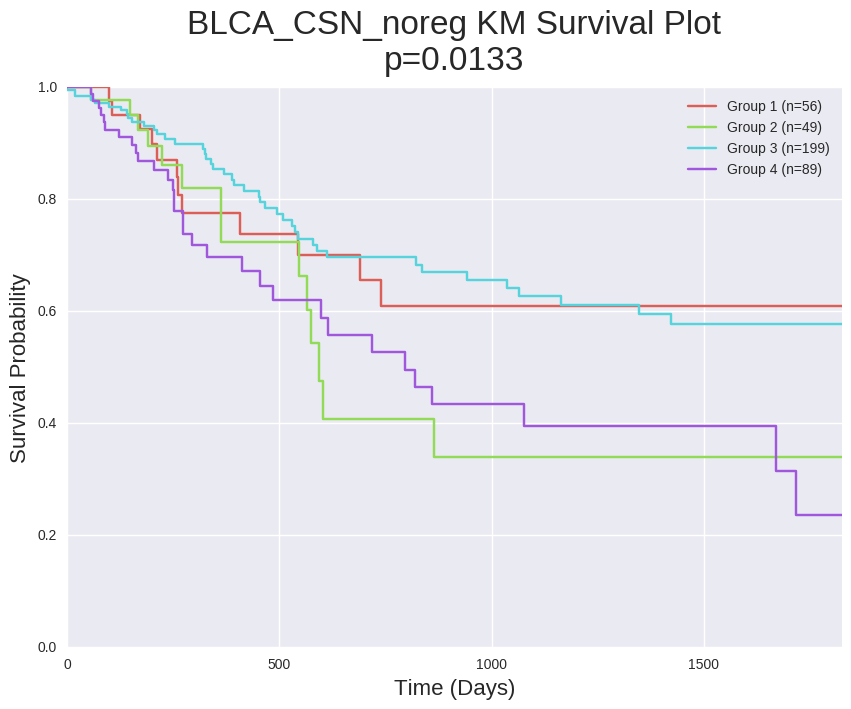

In [37]:
clusters, niters= 4, 100

# Run pyNBS
BLCA_CSN_noreg_Hlist = []
for i in range(niter):
    # Run pyNBS core steps and save resulting H matrix to Hlist
    BLCA_CSN_noreg_Hlist.append(pyNBS_single.NBS_single(sm_mat, CSN_knnGlap, k=clusters, **NBS_single_params))

# Consensus Clustering
BLCA_CSN_noreg_NBS_cc_table, BLCA_CSN_noreg_NBS_cc_linkage, BLCA_CSN_noreg_NBS_cluster_assign = cc.consensus_hclust_hard(BLCA_CSN_noreg_Hlist, k=clusters, **save_args)

# Plot KM Plot for patient clusters
BLCA_CSN_noreg_p = plot.cluster_KMplot(BLCA_CSN_noreg_NBS_cluster_assign, BLCA_surv_data, delimiter=',', **save_args)
Image(filename = save_args['outdir']+save_args['job_name']+'_KM_plot.png', width=600, height=600)

### Agreement with BLCA pyNBS results under normal algorithm deployment
We now use the similarity techniques when comparing pyNBS results to the original Hofree et al results (see the [```OV```]() or [```UCEC```]() Hofree examples for more details) to compare the results of this pyNBS run to the base BLCA pyNBS results with default values on the cancer subnetwork with k=4.

In [39]:
cc_align = pd.concat([BLCA_CSN_NBS_cluster_assign, BLCA_CSN_noreg_NBS_cluster_assign], axis=1).dropna()
cc_align.columns = ['Base', 'New']
base_clust_assign, new_clust_assign = cc_align['Base'], cc_align['New']
adj_rand_index = adjusted_rand_score(base_clust_assign, new_clust_assign)
adj_mutual_info_score = adjusted_mutual_info_score(base_clust_assign, new_clust_assign)
print 'Adjusted Rand Index is: ' + str(adj_rand_index)
print 'Adjusted Mutual Info Score is: ' + str(adj_mutual_info_score)

Adjusted Rand Index is: 0.127131501712
Adjusted Mutual Info Score is: 0.130439735616


In [40]:
# Construct contingency table for cluster assignments
intersect_pats = list(cc_align.index)
NBS_cont_table_array = []
for i in range(1,clusters+1):    
    base_cluster = set(base_clust_assign.ix[intersect_pats][base_clust_assign.ix[intersect_pats]==i].index)
    base_pyNBS_cluster_intersect = []
    for j in range(1,clusters+1):
        new_cluster = set(new_clust_assign.ix[intersect_pats][new_clust_assign.ix[intersect_pats]==j].index)
        base_pyNBS_cluster_intersect.append(len(base_cluster.intersection(new_cluster)))
    NBS_cont_table_array.append(base_pyNBS_cluster_intersect)
    
# Display contingency table
pd.DataFrame(NBS_cont_table_array, 
             index=['Original pyNBS Cluster '+repr(i) for i in range(1, clusters+1)],
             columns=['New pyNBS Cluster '+repr(i) for i in range(1, clusters+1)])

,New pyNBS Cluster 1,New pyNBS Cluster 2,New pyNBS Cluster 3,New pyNBS Cluster 4
Original pyNBS Cluster 1,3,10,113,30
Original pyNBS Cluster 2,3,4,10,2
Original pyNBS Cluster 3,15,32,58,52
Original pyNBS Cluster 4,35,3,18,5


In [41]:
# Calculate p-value and chi-squared statistic:
chi_sq_test = stats.chi2_contingency(NBS_cont_table_array, correction=False)
print 'Chi-Squared Statistic:', chi_sq_test[0]
print 'Chi-Squared P-Value:', chi_sq_test[1]

Chi-Squared Statistic: 156.222826757
Chi-Squared P-Value: 4.52006092993e-29


# pyNBS on BLCA with no consensus clustering
Here, we perform the pyNBS algorithm using the BLCA data, the cancer subnetwork and default settings with k=4. However, we will perform the algorithm without any consensus clustering but rather set both subsampling parameters to 1.0 (see [```subsample_sm_mat```](https://github.com/huangger/pyNBS/wiki/pyNBS.pyNBS_core.subsample_sm_mat) for more details). 

In [42]:
# Optional: Setting a filename prefix for all files saved to outdir
save_args['job_name'] = 'BLCA_CSN_nocc'
# Setting subsampling parameters
NBS_single_params2 = {'pats_subsample_p':'1'}
NBS_single_params2 = {'gene_subsample_p':'1'}

Multi-Class Log-Rank P: 0.0162618798524
Kaplan Meier Plot constructed


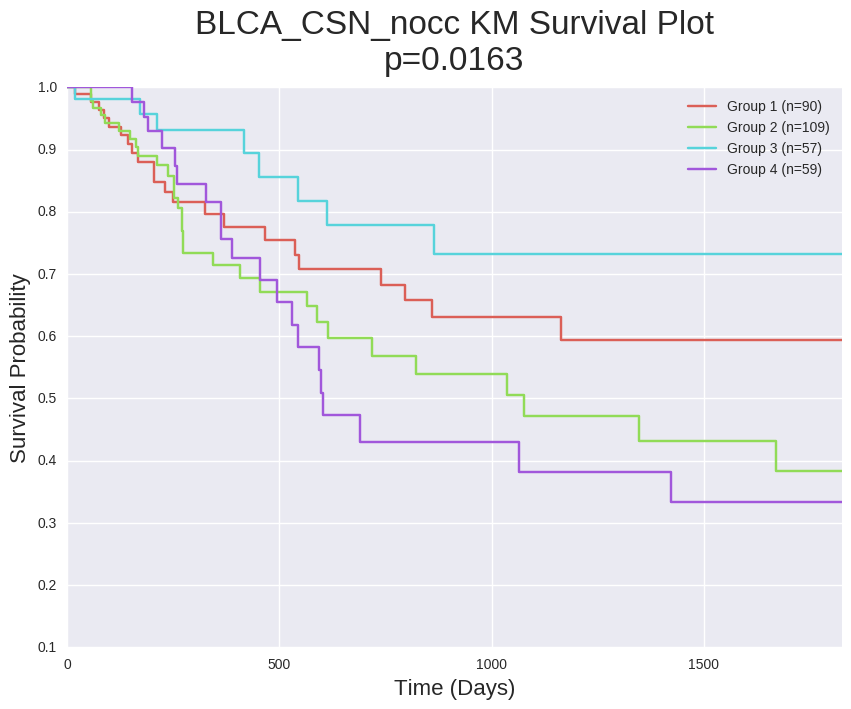

In [45]:
clusters, niters= 4, 100

# Run pyNBS
BLCA_CSN_nocc_H = pyNBS_single.NBS_single(sm_mat, CSN_knnGlap, propNet=CSN, propNet_kernel=CSN_kernel, k=clusters)

# Hard clustering (no consensus)
BLCA_CSN_nocc_H.columns = range(1,len(BLCA_CSN_nocc_H.columns)+1)
BLCA_CSN_nocc_cluster_assign_dict = {}
for pat in BLCA_CSN_nocc_H.index:
    BLCA_CSN_nocc_cluster_assign_dict[pat] = np.argmax(BLCA_CSN_nocc_H.ix[pat])
BLCA_CSN_nocc_cluster_assign = pd.Series(BLCA_CSN_nocc_cluster_assign_dict, name='CC Hard, k='+repr(clusters))
save_clusters_path = save_args['outdir']+str(save_args['job_name'])+'_cluster_assignments.csv'
BLCA_CSN_nocc_cluster_assign.to_csv(save_clusters_path)

# Plot KM Plot for patient clusters
BLCA_CSN_nocc_p = plot.cluster_KMplot(BLCA_CSN_nocc_cluster_assign, BLCA_surv_data, delimiter=',', **save_args)
Image(filename = save_args['outdir']+save_args['job_name']+'_KM_plot.png', width=600, height=600)

### Agreement with BLCA pyNBS results under normal algorithm deployment
We now use the similarity techniques when comparing pyNBS results to the original Hofree et al results (see the [```OV```]() or [```UCEC```]() Hofree examples for more details) to compare the results of this pyNBS run to the base BLCA pyNBS results with default values on the cancer subnetwork with k=4.

In [46]:
cc_align = pd.concat([BLCA_CSN_NBS_cluster_assign, BLCA_CSN_nocc_cluster_assign], axis=1).dropna()
cc_align.columns = ['Base', 'New']
base_clust_assign, new_clust_assign = cc_align['Base'], cc_align['New']
adj_rand_index = adjusted_rand_score(base_clust_assign, new_clust_assign)
adj_mutual_info_score = adjusted_mutual_info_score(base_clust_assign, new_clust_assign)
print 'Adjusted Rand Index is: ' + str(adj_rand_index)
print 'Adjusted Mutual Info Score is: ' + str(adj_mutual_info_score)

Adjusted Rand Index is: 0.304234730035
Adjusted Mutual Info Score is: 0.280458599074


In [47]:
# Construct contingency table for cluster assignments
intersect_pats = list(cc_align.index)
NBS_cont_table_array = []
for i in range(1,clusters+1):    
    base_cluster = set(base_clust_assign.ix[intersect_pats][base_clust_assign.ix[intersect_pats]==i].index)
    base_pyNBS_cluster_intersect = []
    for j in range(1,clusters+1):
        new_cluster = set(new_clust_assign.ix[intersect_pats][new_clust_assign.ix[intersect_pats]==j].index)
        base_pyNBS_cluster_intersect.append(len(base_cluster.intersection(new_cluster)))
    NBS_cont_table_array.append(base_pyNBS_cluster_intersect)
    
# Display contingency table
pd.DataFrame(NBS_cont_table_array, 
             index=['Original pyNBS Cluster '+repr(i) for i in range(1, clusters+1)],
             columns=['New pyNBS Cluster '+repr(i) for i in range(1, clusters+1)])

,New pyNBS Cluster 1,New pyNBS Cluster 2,New pyNBS Cluster 3,New pyNBS Cluster 4
Original pyNBS Cluster 1,78,6,35,7
Original pyNBS Cluster 2,1,3,5,9
Original pyNBS Cluster 3,10,76,1,38
Original pyNBS Cluster 4,1,24,16,5


In [48]:
# Calculate p-value and chi-squared statistic:
chi_sq_test = stats.chi2_contingency(NBS_cont_table_array, correction=False)
print 'Chi-Squared Statistic:', chi_sq_test[0]
print 'Chi-Squared P-Value:', chi_sq_test[1]

Chi-Squared Statistic: 211.946848022
Chi-Squared P-Value: 1.03113535351e-40
